In [44]:
import Pkg
Pkg.activate("MMLDS_project")

#SINDy
#Pkg.add("DataDrivenDiffEq")
#Pkg.add("DataDrivenSparse")

#RESERVOIR 
#Pkg.update()
#Pkg.instantiate()
#Pkg.add("ProgressMeter")
#Pkg.add("DynamicalSystems")
#Pkg.add("ReservoirComputing")
#Pkg.add("Plots")
#Pkg.add("Printf")
#Pkg.add("DifferentialEquations")
#Pkg.add("OrdinaryDiffEq")
#Pkg.add("NetCDF")
#Pkg.add("JLD2")

#SINDy
using DataDrivenDiffEq
using DataDrivenSparse
#using Subscripts #not working yet, took part of the code

#RESERVOIR
using ProgressMeter
using DynamicalSystems, ReservoirComputing, Plots, Printf
using DifferentialEquations
using OrdinaryDiffEq
using NetCDF
#using JLD2


#for estimating the lyapunov exponent from a trajectory:
#Pkg.add("CairoMakie")
using CairoMakie
#Pkg.add("NearestNeighbors")
using NearestNeighbors

#Pkg.add("ChaosTools")
using ChaosTools

#Pkg.add("PyPlot")
#using PyPlot

  Activating project at `~/Documents/GitHub/compare_ML_DynamicalSystem/MMLDS_project/src/MMLDS_project`


In [45]:
include("data.jl")
include("SINDy.jl")

train_SINDy (generic function with 4 methods)

In [46]:
#Loading and changing El Nino Data
path_to_data = "sst.mon.mean.nc"

x = ncread(path_to_data, "sst") #sst = Sea Surface Temperature
x_reduced = x[121:170, 86:95, :] #only concerned with the important region for the El Nino happening

X_vector = compress_data_matrix(x_reduced, 5, false, true)

20×2040 Matrix{Float64}:
 28.0325  27.8742  28.1076  28.688   …  28.621   29.4195  29.5172  29.0083
 28.2426  28.2316  28.488   28.9117     28.3489  29.3835  29.6865  29.3908
 28.5179  28.6131  28.8473  29.1355     28.6434  29.723   29.7411  29.3795
 28.84    28.8382  29.0742  29.1841     29.4347  30.2484  29.8994  29.4668
 29.023   28.9616  29.1702  29.2372     29.4146  30.2277  29.8914  29.5535
 29.1572  29.1256  29.2598  29.2776  …  29.7037  30.4001  30.031   29.7284
 29.1264  29.117   29.196   29.2381     29.8099  30.4189  30.0984  29.8489
 28.9993  29.0324  29.076   29.1209     30.1048  30.5088  30.2152  29.9283
 28.7191  28.7542  28.6979  28.8395     30.32    30.6631  30.3864  30.0508
 28.4407  28.3725  28.2181  28.6071     30.32    30.5643  30.4019  30.1978
 28.7257  28.5573  28.5916  28.9932  …  27.2255  28.4254  29.3495  29.8018
 28.7958  28.7403  28.7715  29.102      26.6425  28.0568  29.141   29.8132
 28.8938  28.9374  28.9322  29.1185     27.5829  28.7421  29.3249  29.7972


Model ##Basis#519 with 20 equations
States : 20
Parameters : 374
Independent variable: t
Equations
Difference(t; dt=1.0, update=false)((x(t))[1]) = p₁*sin((1//2)*(x(t))[1]) + p₂*sin((1//2)*(x(t))[2]) + p₃*sin((1//2)*(x(t))[3]) + p₄*sin((1//2)*(x(t))[4]) + p₅*sin((1//2)*(x(t))[5]) + p₆*sin((1//2)*(x(t))[6]) + p₇*sin((1//2)*(x(t))[7]) + p₈*sin((1//2)*(x(t))[8]) + p₁₀*sin((1//2)*(x(t))[10]) + p₁₁*sin((1//2)*(x(t))[11]) + p₁₂*sin((1//2)*(x(t))[12]) + p₁₃*sin((1//2)*(x(t))[13]) + p₁₄*sin((1//2)*(x(t))[14]) + p₁₅*sin((1//2)*(x(t))[15]) + p₁₆*sin((1//2)*(x(t))[16]) + p₁₇*sin((1//2)*(x(t))[17]) + p₁₈*sin((1//2)*(x(t))[18]) + p₁₉*sin((1//2)*(x(t))[19]) + p₂₀*sin((1//2)*(x(t))[20]) + p₉*sin((1//2)*(x(t))[9])
Difference(t; dt=1.0, update=false)((x(t))[2]) = p₂₁*sin((1//2)*(x(t))[1]) + p₂₂*sin((1//2)*(x(t))[2]) + p₂₃*sin((1//2)*(x(t))[3]) + p₂₄*sin((1//2)*(x(t))[4]) + p₂₅*sin((1//2)*(x(t))[5]) + p₂₆*sin((1//2)*(x(t))[6]) + p₂₇*sin((1//2)*(x(t))[7]) + p₂₈*sin((1//2)*(x(t))[8]) + p₂₉*sin((1//2)*(x(t

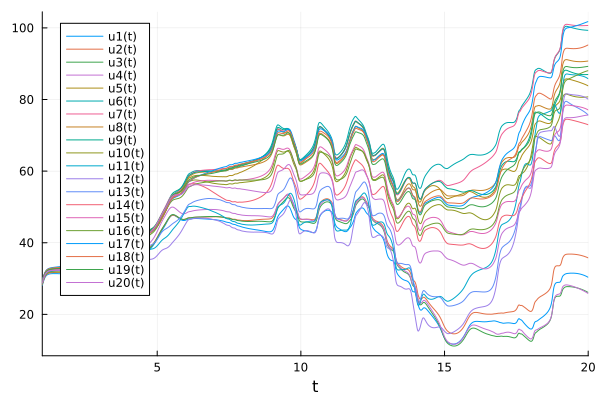

In [47]:
#shrink the dimensions to see if it is working
x_sindy = X_vector[:,:]

#lasso parameter lambda cannot be smaller than 1e-2, otherwise an error occurs
ddsol = train_SINDy(x_sindy, 1e-1, 1e-1, basis = "fourier_basis",n = 1)
ddsol.prob.p[1]

function recovered_dynamics(u,p,t)
    return ddsol(u,p,t)
end


function create_SINDy_trajectory(x0 = [1.,1.,1.],dt = 1, tstart = 1., tend = 20.)

    p_SINDy = ddsol.prob.p
    tspan = (tstart, tend)
    saveat = tstart:dt:tend
    
    prob = ODEProblem(recovered_dynamics, x0, tspan, p_SINDy) 
    sol = solve(prob, Tsit5(), saveat=saveat)
    return sol
end

sol_sindy = create_SINDy_trajectory(X_vector[:,1],.005,1,20)
Plots.plot(sol_sindy)

## Try Lyapunov exponent estimation

In [48]:
println(length(sol_sindy[1,:]))

3801


In [56]:
h(u) = u[1, :]
Δt = 0.1
s = h(sol_sindy)

# Estimate the optimal embedding
D, τ, E = optimal_traditional_de(s)

#data_embedded = embed(s, 5,17)
#println(length(data_embedded)-k_values[end])

Algorithm stopped due to convergence of E₁-statistic. Valid embedding achieved ✓.


(3-dimensional Dataset{Float64} with 3749 points, 26, [0.0027335470181244445, 0.27837320538887755, 0.8944817184143175, 0.9262978025622247, 0.9683782672134158, 0.9765437095157744, 0.986108447010981, 0.9895820311860535, 0.9903888633942519, 0.9948983633652176])

┌ Warning: Found linear region spans less than a 3rd of the available x-axis and might imply inaccurate slope or insufficient data. Recommended: plot `x` vs `y`.
└ @ ChaosTools /home/tom/.julia/packages/ChaosTools/PHPDF/src/dimensions/linear_regions.jl:143
┌ Warning: Found linear region spans less than a 3rd of the available x-axis and might imply inaccurate slope or insufficient data. Recommended: plot `x` vs `y`.
└ @ ChaosTools /home/tom/.julia/packages/ChaosTools/PHPDF/src/dimensions/linear_regions.jl:143


┌ Warning: Found linear region spans less than a 3rd of the available x-axis and might imply inaccurate slope or insufficient data. Recommended: plot `x` vs `y`.
└ @ ChaosTools /home/tom/.julia/packages/ChaosTools/PHPDF/src/dimensions/linear_regions.jl:143
┌ Warning: Found linear region spans less than a 3rd of the available x-axis and might imply inaccurate slope or insufficient data. Recommended: plot `x` vs `y`.
└ @ ChaosTools /home/tom/.julia/packages/ChaosTools/PHPDF/src/dimensions/linear_regions.jl:143
┌ Warning: Found linear region spans less than a 3rd of the available x-axis and might imply inaccurate slope or insufficient data. Recommended: plot `x` vs `y`.
└ @ ChaosTools /home/tom/.julia/packages/ChaosTools/PHPDF/src/dimensions/linear_regions.jl:143
┌ Warning: Found linear region spans less than a 3rd of the available x-axis and might imply inaccurate slope or insufficient data. Recommended: plot `x` vs `y`.
└ @ ChaosTools /home/tom/.julia/packages/ChaosTools/PHPDF/src/dimen

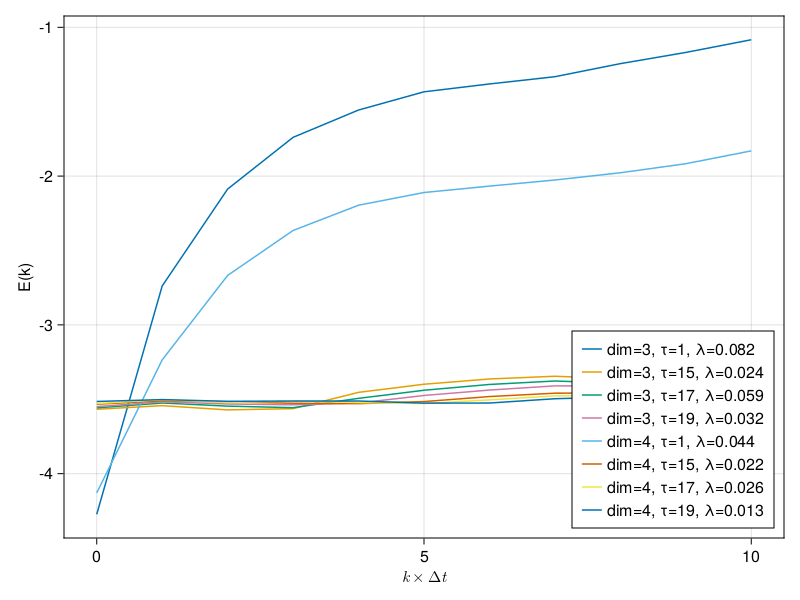

In [57]:
k_values = 0:10:100  # Integer timesteps k * Δt

fig = CairoMakie.Figure(figsize = (500, 500))
ax = CairoMakie.Axis(fig[1, 1], xlabel = L"k \times Δt", ylabel="E(k)")

for dim in [3, 4], τ in [1, 15, 17, 19]  # Try different embedding dimensions and time delays
    data_embedded = embed(s, dim, τ)
    E = lyapunov_from_data(data_embedded, k_values)  # Returns [E(k) for k ∈ k_values]
    λ = linear_region(k_values .* Δt, E)[2]          # Returns the slope of the linear region, i.e. the Lyapunov exponent
    lines!(
        ax, 
        k_values .* Δt, 
        E, 
        label = "dim=$(dim), τ=$(τ), λ=$(round(λ, digits = 3))",
    )
end

axislegend(ax, position = :rb)
fig

In [51]:
function plot_SINDy_and_ElNino_trajectories(savePath, X_vector, sindy_sol)
    n, s = size(sindy_sol)
    for i in 1:n
        i_data = X_vector[i, 1:100]
        p = Plots.plot(i_data, idxs=[1], tspan=(0, 100), label="El Nino Data", title="on real world data")
        p = Plots.plot!(sindy_sol[i,1:100], idxs=[1], tspan=(0, 100), label="SINDy")
        saveEnding = string(i)
        savePath_currently = savePath*"trajectory_" * string(saveEnding)*".png" 
        Plots.savefig(p, savePath_currently)
    end
end


plot_SINDy_and_ElNino_trajectories (generic function with 1 method)

In [52]:
#sol = create_SINDy_trajectory()
savePath = "/home/tom/Documents/GitHub/compare_ML_DynamicalSystem/MMLDS_project/Plots/SINDy/"
#savePath = "C:/Users/tomfi/Desktop/Uni/3M_semester/Project_MMLDS/MMLDS_2/MMLDS_project/plots/"
plot_SINDy_and_ElNino_trajectories(savePath, X_vector, sol_sindy)

In [53]:
println(sol_sindy[1,1:100])

[28.032480239868164, 28.176260405724655, 28.320623583376783, 28.464697682004704, 28.60768087042258, 28.748841577078533, 28.88751849005471, 29.023120557067212, 29.155126985466154, 29.28308724223562, 29.406621053993707, 29.52541840699246, 29.639239547117974, 29.74791497989026, 29.851345470463386, 29.949502043625362, 30.042425983798196, 30.130228835037883, 30.213092401034444, 30.291268745111832, 30.36507947009925, 30.43462090449632, 30.499917640128693, 30.561162227159784, 30.61854560978371, 30.672257126225258, 30.72248450873993, 30.769413883613918, 30.813229771164085, 30.85411508573801, 30.892251135713952, 30.927817623500864, 30.96099264553839, 30.991952836366163, 31.020879947005927, 31.04789835277242, 31.07310483945007, 31.096594426626883, 31.11846036769444, 31.138794149847893, 31.157685494085978, 31.175222355210998, 31.191490921828837, 31.206575616348957, 31.220559094984388, 31.233522247751736, 31.24554419847119, 31.256702304766513, 31.267072158065034, 31.27672758359767, 31.285740640398